Use and timing of threshold rebin method compared to standard PMap rebinning

In [31]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt

from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.reco.pmaps_functions import           rebin_peak
from invisible_cities.reco.pmaps_functions import get_threshold_slices
from invisible_cities.reco.pmaps_functions import      get_even_slices
from invisible_cities.reco.pmaps_functions import          RebinMethod

plt.rcParams["figure.figsize"] = 10, 7.5

pmaps = load_pmaps('pmaps_0000_6238_trg2_v0.9.9_20180727_krth1300.h5')


In [32]:
pmt_sum = pmaps[1].s2s[0].pmts.sum_over_sensors
## PMT sum threshold of 9000 pe, approximately low raw energy minimum for Kr
threshold = 9000
%timeit -o get_even_slices(pmaps[1].s2s[0].times.shape[0], 2)
%timeit -o get_threshold_slices(pmt_sum, threshold)

4.68 µs ± 31 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
73.1 µs ± 841 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 73.1 µs ± 841 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [33]:
%timeit -o rebin_peak(pmaps[1].s2s[0], 2)
%timeit -o rebin_peak(pmaps[1].s2s[0], threshold, RebinMethod.threshold)

1.71 ms ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.67 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 1.67 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

How does the rebinning work

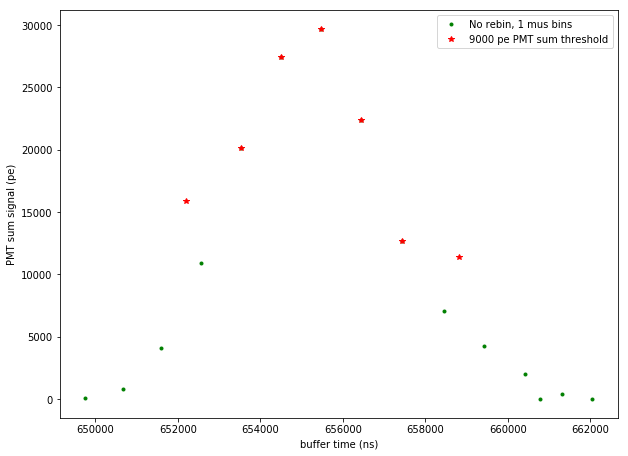

In [34]:
reb_pk_stand = rebin_peak(pmaps[1].s2s[0], 2)
reb_pk_threh = rebin_peak(pmaps[1].s2s[0], threshold, RebinMethod.threshold)
plt.errorbar(pmaps[1].s2s[0].times, pmaps[1].s2s[0].pmts.sum_over_sensors, fmt='g.', label='No rebin, 1 mus bins')
#plt.errorbar(reb_pk_stand.times, reb_pk_stand.pmts.sum_over_sensors, fmt='b+', label='2 mus even bins')
plt.errorbar(reb_pk_threh.times, reb_pk_threh.pmts.sum_over_sensors, fmt='r*', label='9000 pe PMT sum threshold')
plt.xlabel('buffer time (ns)')
plt.ylabel('PMT sum signal (pe)')
plt.legend()

And how does that translate to the tracking plane, both without rebin, 2 bin stride and threshold

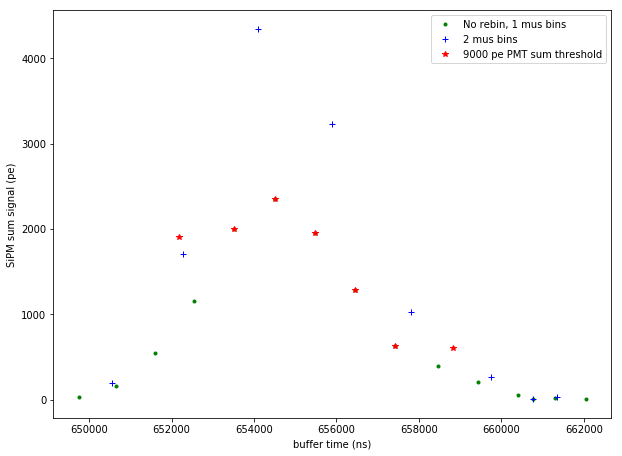

In [35]:
plt.errorbar(pmaps[1].s2s[0].times, pmaps[1].s2s[0].sipms.sum_over_sensors, fmt='g.', label='No rebin, 1 mus bins')
plt.errorbar(reb_pk_stand.times, reb_pk_stand.sipms.sum_over_sensors, fmt='b+', label='2 mus bins')
plt.errorbar(reb_pk_threh.times, reb_pk_threh.sipms.sum_over_sensors, fmt='r*', label='9000 pe PMT sum threshold')
plt.xlabel('buffer time (ns)')
plt.ylabel('SiPM sum signal (pe)')
plt.legend()

Looking at the sipm with maximum charge for each slice

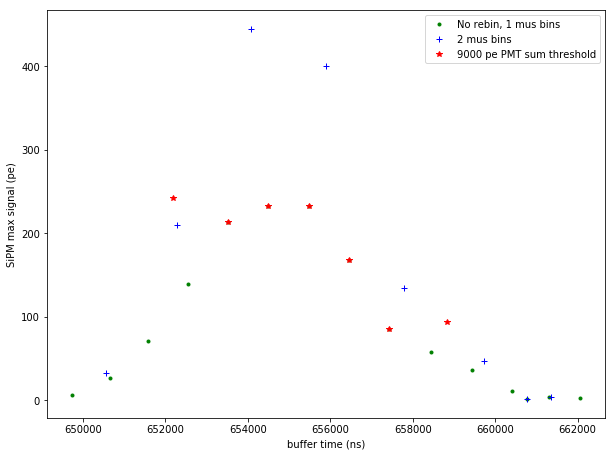

In [36]:
max_array_1mus = pmaps[1].s2s[0].sipms.all_waveforms.max(axis=0)
max_array_2mus = reb_pk_stand.sipms.all_waveforms.max(axis=0)
max_array_thre = reb_pk_threh.sipms.all_waveforms.max(axis=0)
plt.errorbar(pmaps[1].s2s[0].times, max_array_1mus, fmt='g.', label='No rebin, 1 mus bins')
plt.errorbar(reb_pk_stand.times, max_array_2mus, fmt='b+', label='2 mus bins')
plt.errorbar(reb_pk_threh.times, max_array_thre, fmt='r*', label='9000 pe PMT sum threshold')
plt.xlabel('buffer time (ns)')
plt.ylabel('SiPM max signal (pe)')
plt.legend()

Event at 2 mus where some slices have a huge amount of charge there are some with a tiny amount. However, with the threshold method all slices have tracking plane information at levels for reliable reconstruction.

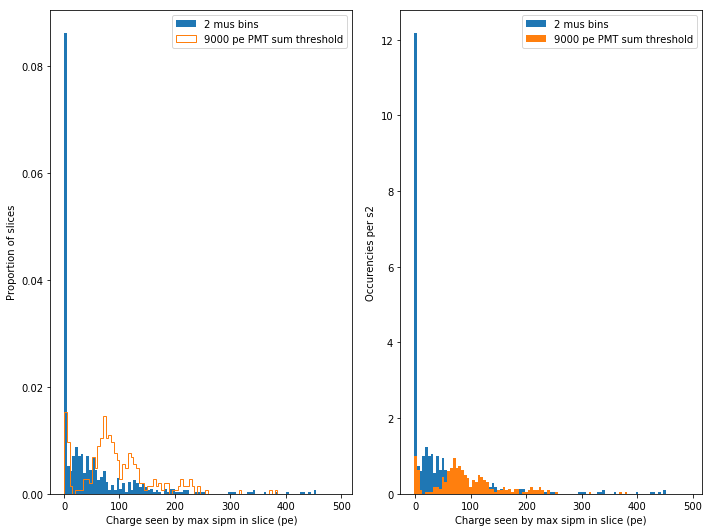

In [37]:
maxes_stand = []
maxes_threh = []
n_s2s       = 0
for pmap in pmaps.values():
    for s2 in pmap.s2s:
        n_s2s += 1
        reb_stand = rebin_peak(s2, 2)
        reb_threh = rebin_peak(s2, threshold, RebinMethod.threshold)
        maxes_stand.append(reb_stand.sipms.all_waveforms.max(axis=0))
        maxes_threh.append(reb_threh.sipms.all_waveforms.max(axis=0))
        
plt.subplot(1, 2, 1)
plt.hist(np.concatenate(maxes_stand), bins=np.arange(0, 500, 5), label='2 mus bins', density=True)
plt.hist(np.concatenate(maxes_threh), bins=np.arange(0, 500, 5), label='9000 pe PMT sum threshold', density=True, histtype='step')
plt.xlabel('Charge seen by max sipm in slice (pe)')
plt.ylabel('Proportion of slices')
plt.legend()

plt.subplot(1, 2, 2)
hist_stand, bins_stand = np.histogram(np.concatenate(maxes_stand), bins=np.arange(0, 500, 5))
hist_threh, bins_threh = np.histogram(np.concatenate(maxes_threh), bins=np.arange(0, 500, 5))
wids_stand = np.diff(bins_stand)
wids_threh = np.diff(bins_threh)
plt.bar(bins_stand[:-1], hist_stand / n_s2s, wids_stand, label='2 mus bins')
plt.bar(bins_threh[:-1], hist_threh / n_s2s, wids_threh, label='9000 pe PMT sum threshold')
plt.xlabel('Charge seen by max sipm in slice (pe)')
plt.ylabel('Occurencies per s2')
plt.legend()
plt.tight_layout()

Looking at all S2s in the file we find that the occurence of slicess with max sipm charge below 5 pe is vanishing for the threshold rebin but remains frequent for 2 mus rebinning

In [38]:
def test_slice_gen(pmt_sum, thresh):
    def slice_generator():
        i = 0
        j = 1
        while i < len(pmt_sum):
            while pmt_sum[i:j].sum() < thresh and j < len(pmt_sum):
                j += 1
            yield slice(i, j)
            i = j
            j += 1
    slices = [sl for sl in slice_generator()]
    if pmt_sum[slices[-1]].sum() < thresh:
        slices[-2:] = [slice(slices[-2].start, slices[-1].stop)]
    return slices

In [39]:
test1 = test_slice_gen(pmt_sum, threshold)
print(test1)

[slice(0, 4, None), slice(4, 5, None), slice(5, 6, None), slice(6, 7, None), slice(7, 8, None), slice(8, 9, None), slice(9, 15, None)]


In [40]:
%timeit -o test_slice_gen(pmt_sum, threshold)

181 µs ± 64.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 181 µs ± 64.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [41]:
def test2_slice_gen(pmt_sum, thresh):
    def slice_generator():
        last_index = 0
        last_sum   = 0
        for i, sum_val in enumerate(np.cumsum(pmt_sum)):
            if sum_val - last_sum >= thresh or i + 1 == len(pmt_sum):
                yield slice(last_index, i + 1)
                last_index = i + 1
                last_sum   = sum_val
    slices = [sl for sl in slice_generator()]
    if pmt_sum[slices[-1]].sum() < thresh:
        last_slice = [slice(slices[-2].start, slices[-1].stop)]
        slices[-2:] = last_slice
    return slices

In [42]:
test2 = test2_slice_gen(pmt_sum, threshold)
print(test2)

[slice(0, 4, None), slice(4, 5, None), slice(5, 6, None), slice(6, 7, None), slice(7, 8, None), slice(8, 9, None), slice(9, 15, None)]


In [43]:
%timeit -o test2_slice_gen(pmt_sum, threshold)

71.4 µs ± 489 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 71.4 µs ± 489 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [44]:
def test3_slice_gen(psum, thresh):
    csum = np.cumsum(psum)
    indcs = np.argwhere(np.repeat(csum[None, :], len(pmt_sum), 0) - np.insert(csum[:-1], 0, 0)[:, np.newaxis] > thresh)
#repSum = np.repeat(csum[None, :], len(pmt_sum), 0) - np.insert(csum[:-1], 0, 0)[:, np.newaxis] #- np.full((pmt_sum.shape[0], 1), threshold)
#repSum
#np.argwhere(repSum >= threshold)
#indcs = np.argwhere(repSum >= threshold)
#np.cumsum(np.bincount(indcs[:, 0]))
    bin_sum = np.cumsum(np.bincount(indcs[:, 0]))
    slices = [slice(indcs[0][0], indcs[0][1] + 1)]
    while slices[-1].stop in indcs[:, 0]:
        row_indx = bin_sum[slices[-1].stop-1]
        slices.append(slice(slices[-1].stop, indcs[row_indx][0] + 1))
    if slices[-1].stop != len(pmt_sum):
        slices[-1] = [slice(slices[-1].start, len(pmt_sum))]
#print(slices)
#print(indcs[0], indcs[bins[indcs[0][1]]], indcs[bins[13]], indcs[bins[18]])
#print(pmt_sum[0:9].sum(), pmt_sum[9:14].sum(), pmt_sum[14:18].sum())

In [45]:
%timeit -o test3_slice_gen(pmt_sum, threshold)

138 µs ± 8.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 138 µs ± 8.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>